In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dku-data-science/rtu_data_full.csv
/kaggle/input/dku-data-science/submissionfile_sample.csv
/kaggle/input/dku-data-science/train.csv
/kaggle/input/dku-data-science/test.csv


In [2]:
# ! pip install holidays

# 0. 필요한 패키지 설치

In [3]:
import holidays
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

# 1. 데이터 불러오기

In [4]:
df_train = pd.read_csv('/kaggle/input/dku-data-science/rtu_data_full.csv')

# 2. 전처리

In [5]:
# datetime 컬럼 생성
df_train['datetime'] = pd.to_datetime(df_train['localtime'], format='%Y%m%d%H%M%S')
df_train.set_index('datetime', inplace=True)
df_train = df_train.sort_index()

In [6]:
# 복제본 생성
df = df_train.copy()

In [7]:
# 3. 필요없는 컬럼 제거
drop_cols = ['timestamp', 'operation']
df = df.drop(columns=[col for col in drop_cols if col in df_train.columns])

In [8]:
# activePower → kWh 단위 변환
# activePower: 5초 단위 측정이므로 kWh = activePower × (5 / 3600)
df['activePower_kWh'] = df['activePower'] * (5 / 3600)

# 3. 파생변수 생성

## 3-1. 전기적 이상 탐지 지표 파생변수

In [9]:
# 평균 전압 / 전류
df['voltage_avg'] = df[['voltageR', 'voltageS', 'voltageT']].mean(axis=1)
df['current_avg'] = df[['currentR', 'currentS', 'currentT']].mean(axis=1)

# 최대-최소 차이 (부하 불균형)
df['voltage_diff'] = df[['voltageR', 'voltageS', 'voltageT']].max(axis=1) - df[['voltageR', 'voltageS', 'voltageT']].min(axis=1)
df['current_diff'] = df[['currentR', 'currentS', 'currentT']].max(axis=1) - df[['currentR', 'currentS', 'currentT']].min(axis=1)

# 표준편차 (급변성 탐지)
df['voltage_std'] = df[['voltageR', 'voltageS', 'voltageT']].std(axis=1)
df['current_std'] = df[['currentR', 'currentS', 'currentT']].std(axis=1)

# 전압/전류 급변 플래그 (5초 전 대비 변화량 기준)
df['voltage_spike'] = ((df['voltage_avg'].pct_change().abs()) > 0.05).astype(int)
df['current_spike'] = (df['current_avg'].diff().abs() > 1.0).astype(int)  # 예: 1A 이상 급변

# 역률 급변 플래그
df['pf_avg'] = df[['powerFactorR', 'powerFactorS', 'powerFactorT']].mean(axis=1)
df['pf_spike'] = (df['pf_avg'].diff().abs() > 0.02).astype(int)  # 2% 이상 급변이면 이상

In [10]:
df_hourly = df.resample('H').agg({
    'activePower_kWh' : 'sum',
    'voltage_avg': 'mean',
    'current_avg': 'mean',
    'voltage_diff': 'mean',
    'current_diff': 'mean',
    'voltage_std': 'mean',
    'current_std': 'mean',
    'voltage_spike': 'sum',  # 해당 시간 동안 급변 횟수
    'current_spike': 'sum',
    'pf_spike': 'sum'
}).dropna()

/tmp/ipykernel_13/1003214175.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').agg({


## 3-2. 시간 공휴일 및 비 영업일 파생변수 생성

In [11]:
import holidays
# 시간 파생 변수 추가
# 🇰🇷 한국 공휴일 객체 생성 (예: 2024, 2025 포함)
kr_holidays = holidays.KR(years=[2024, 2025])

df_hourly['hour'] = df_hourly.index.hour
df_hourly['weekday'] = df_hourly.index.weekday
df_hourly['is_weekend'] = (df_hourly['weekday'] >= 5).astype(int)
df_hourly['is_night'] = ((df_hourly['hour'] < 6) | (df_hourly['hour'] >= 22)).astype(int)
df_hourly['hour_sin'] = np.sin(2 * np.pi * df_hourly['hour'] / 24)
df_hourly['hour_cos'] = np.cos(2 * np.pi * df_hourly['hour'] / 24)
df_hourly['is_holiday'] = df_hourly.index.to_series().apply(lambda x: 1 if x.date() in kr_holidays else 0)
df_hourly['is_weekend_or_holiday'] = ((df_hourly['is_weekend'] == 1) | (df_hourly['is_holiday'] == 1)).astype(int)

## 3-3. 계절 파생변수 생성

In [12]:
# 월 추출
df_hourly['month'] = df_hourly.index.month

# 계절 라벨 함수 정의
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# 계절 컬럼 생성
df_hourly['season'] = df_hourly['month'].apply(get_season)

# One-Hot 인코딩
season_dummies = pd.get_dummies(df_hourly['season'], prefix='season')

# 실제 데이터에 존재하는 계절만 포함 (불필요한 all-zero 컬럼 제거)
season_cols = [col for col in season_dummies.columns if season_dummies[col].sum() > 0]
df_hourly = pd.concat([df_hourly, season_dummies[season_cols]], axis=1)

# 4. 학습에 사용할 최종 Feature Set

In [13]:
# 학습/예측에 사용할 최종 Feature Set
feature_cols = [
    'voltage_avg', 'current_avg',
    'voltage_diff', 
    'current_diff',
    'voltage_std', 'current_std','voltage_spike', 
    'current_spike',
    'pf_spike',
    'hour', 'weekday', 
    'hour_sin',
    'hour_cos', 
    'is_weekend_or_holiday',
    'season_spring'
]

In [14]:
feature_cols

['voltage_avg',
 'current_avg',
 'voltage_diff',
 'current_diff',
 'voltage_std',
 'current_std',
 'voltage_spike',
 'current_spike',
 'pf_spike',
 'hour',
 'weekday',
 'hour_sin',
 'hour_cos',
 'is_weekend_or_holiday',
 'season_spring']

# 5. 모델 학습 및 검증

In [15]:
# 전체 학습 데이터 (12~3월)
train_df = df_hourly[df_hourly.index <= '2025-03-31'].copy()

X_all = train_df[feature_cols].copy()
y_all = train_df['activePower_kWh'].shift(-1)
valid_index = X_all.index.intersection(y_all.dropna().index)
X_all = X_all.loc[valid_index]
y_all = y_all.loc[valid_index]

# 3월까지 전체로 모델 학습
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8, random_state=42)
model.fit(X_all, y_all)

# 4월 데이터로 검증
val_df = df_hourly[(df_hourly.index >= '2025-04-01') & (df_hourly.index <= '2025-04-29')].copy()
X_val = val_df[feature_cols].copy()
y_val = val_df['activePower_kWh'].shift(-1)

valid_val_idx = X_val.index.intersection(y_val.dropna().index)
X_val = X_val.loc[valid_val_idx]
y_val = y_val.loc[valid_val_idx]

val_preds = model.predict(X_val)

# 성능 평가
rmse = mean_squared_error(y_val, val_preds, squared=False)
mae = mean_absolute_error(y_val, val_preds)

print("\n 4월 검증 성능:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")


 4월 검증 성능:
RMSE: 99.24
MAE:  80.39


# 6. 예측 입력 생성 및 미래 전력 소비량 예측

In [16]:
# 1. 예측용 시간 생성
future = pd.DataFrame()
future['datetime'] = pd.date_range("2025-05-01", "2025-05-28 23:00:00", freq='H')
future.set_index('datetime', inplace=True)

# 시간 파생 변수 추가
# 🇰🇷 한국 공휴일 객체 생성 (예: 2024, 2025 포함)
kr_holidays = holidays.KR(years=[2024, 2025])

# 올바른 시간 파생 변수 계산 (future 자체 기준)
future['hour'] = future.index.hour
future['weekday'] = future.index.weekday
future['is_weekend'] = (future['weekday'] >= 5).astype(int)
future['is_night'] = ((future['hour'] < 6) | (future['hour'] >= 22)).astype(int)
future['hour_sin'] = np.sin(2 * np.pi * future['hour'] / 24)
future['hour_cos'] = np.cos(2 * np.pi * future['hour'] / 24)
future['is_holiday'] = future.index.to_series().apply(lambda x: int(x.date() in kr_holidays))
future['is_weekend_or_holiday'] = ((future['is_weekend'] == 1) | (future['is_holiday'] == 1)).astype(int)

# 3. 센서 기반 변수 평균값으로 채우기
sensor_cols = [
    'voltage_avg', 'current_avg',
    'voltage_diff', 
    'current_diff',
    'voltage_std', 'current_std',
    'voltage_spike',
    'current_spike', 
    'pf_spike'
]
for col in sensor_cols:
    future[col] = df_hourly[col].mean()  # 단, 시간에 따라 변화하지 않는 센서 평균

for season in ['season_spring', 'season_winter']:
    if season not in future.columns:
        future[season] = 0  # 또는 다른 기본값

# 4. feature 추출 및 예측
X_future = future[feature_cols]  # 기존 학습에 사용한 컬럼 순서 그대로
future_preds = model.predict(X_future)
future['predicted_kWh'] = future_preds

/tmp/ipykernel_13/3512398495.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future['datetime'] = pd.date_range("2025-05-01", "2025-05-28 23:00:00", freq='H')


# 7. 예측값에 대한 최종 후처리

In [17]:
# 2. 추가 스케일 보정 (최종 tuning)
final_scale = 0.99848857
future['predicted_kWh_corrected'] = future['predicted_kWh'] * final_scale

# 합계 확인
print("보정된 총 예측 전력량:", future['predicted_kWh_corrected'].sum())

보정된 총 예측 전력량: 26256560.0


In [18]:
# 12월 ~ 4월의 데이터 중 실제 예측 대상 변수 기준
train_val_df = df_hourly[(df_hourly.index >= '2024-12-01') & (df_hourly.index <= '2025-04-29')]
target_col = 'activePower_kWh'

# IQR 계산
Q1 = train_val_df[target_col].quantile(0.25)
Q3 = train_val_df[target_col].quantile(0.75)
IQR = Q3 - Q1

# IQR 범위 기반 하한/상한 설정
actual_min = Q1 - 0.5 * IQR
actual_max = Q3 + 0.5 * IQR

print(f"IQR 기반 최소값(Q1 - 0.5×IQR): {actual_min:.2f}")
print(f"IQR 기반 최대값(Q3 + 0.5×IQR): {actual_max:.2f}")

IQR 기반 최소값(Q1 - 0.5×IQR): 39003.50
IQR 기반 최대값(Q3 + 0.5×IQR): 39256.38


In [19]:
best_score = float('-inf')
best_amplify = None
agg_pow_target = future['predicted_kWh_corrected'].sum()

for a in np.arange(1.0, 20.1, 0.05):  # 진폭 확대 비율을 1.0 ~ 20.1 사이에서 0.05 단위로 탐색
    center = future['predicted_kWh_corrected'].rolling(window=24, center=True, min_periods=1).mean()
    amplified = center + (future['predicted_kWh_corrected'] - center) * a
    scaled_amplified = amplified * (agg_pow_target / amplified.sum())

    # 조건 1: 최소/최대값 범위를 넘지 않아야 함
    if scaled_amplified.min() >= actual_min and scaled_amplified.max() <= actual_max:
        # 예시 점수: 표준편차(진폭)로 평가 → 높을수록 좋음
        score = scaled_amplified.std()

        if score > best_score:
            best_score = score
            best_amplify = a

print(f"최적 진폭 확대 계수: {best_amplify:.2f} (std: {best_score:.2f})")

최적 진폭 확대 계수: 4.35 (std: 32.12)


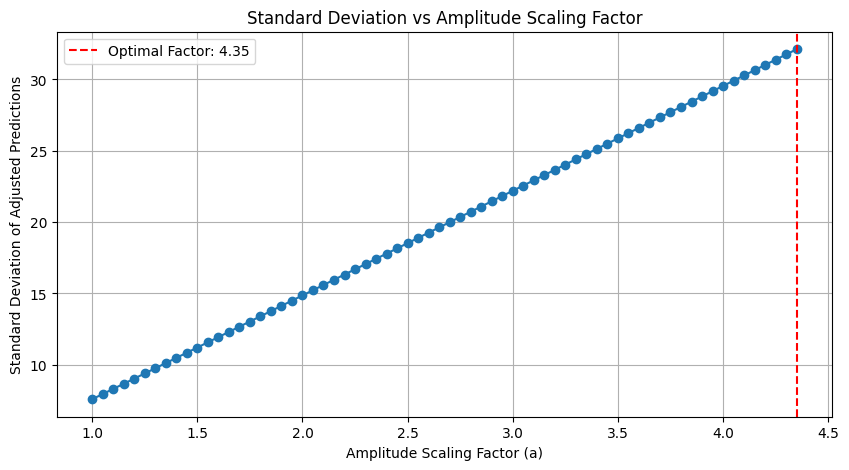

In [20]:
import matplotlib.pyplot as plt

ratios = np.arange(1.0, 12.5, 0.05)
std_list = []
valid_ratios = []

for a in ratios:
    center = future['predicted_kWh_corrected'].rolling(window=24, center=True, min_periods=1).mean()
    amplified = center + (future['predicted_kWh_corrected'] - center) * a
    scaled_amplified = amplified * (agg_pow_target / amplified.sum())

    if scaled_amplified.min() >= actual_min and scaled_amplified.max() <= actual_max:
        std_list.append(scaled_amplified.std())
        valid_ratios.append(a)

plt.figure(figsize=(10, 5))
plt.plot(valid_ratios, std_list, marker='o')
plt.title("Standard Deviation vs Amplitude Scaling Factor")
plt.xlabel("Amplitude Scaling Factor (a)")
plt.ylabel("Standard Deviation of Adjusted Predictions")
plt.grid(True)
plt.axvline(x=best_amplify, color='red', linestyle='--', label=f"Optimal Factor: {best_amplify:.2f}")
plt.legend()
plt.show()

In [21]:
# 위에서 찾은 best_amplify로 결과 생성
center = future['predicted_kWh_corrected'].rolling(window=24, center=True, min_periods=1).mean()
amplified = center + (future['predicted_kWh_corrected'] - center) * best_amplify
final = amplified * (agg_pow_target / amplified.sum())

future['predicted_kWh_final'] = final

# 8. 예측 결과 정리 및 제출 파일 생성
- 최종 예측값을 기반으로 전체 소비량, 요금, 탄소 배출량 계산
- 제출 양식에 맞춰 결과 구성 및 submission.csv 파일로 저장

In [22]:
# 전체 예측량 및 변환 지표
agg_pow = future['predicted_kWh_final'].sum()
may_bill = agg_pow * 180
may_carbon = agg_pow * 0.424

submission = pd.read_csv("/kaggle/input/dku-data-science/submissionfile_sample.csv")

# ID 컬럼 생성
future['id'] = future.index.strftime('%Y-%m-%d %H:%M:%S')

# 제출 파일 구성
submission = pd.DataFrame()
submission['id'] = future['id']
submission['hourly_pow'] = future['predicted_kWh_final']
submission['agg_pow'] = agg_pow
submission['may_bill'] = may_bill
submission['may_carbon'] = may_carbon

# CSV 저장
submission.to_csv('submission_xgb_amplify_435.csv', index=False, float_format="%.6f")
print("submission_xgb_amplify_435.csv 저장 완료")

submission_xgb_amplify_435.csv 저장 완료


### submission 확인

In [23]:
submission

,id,hourly_pow,agg_pow,may_bill,may_carbon
datetime,,,,,
2025-05-01 00:00:00,2025-05-01 00:00:00,39011.850481,26256560.0,4.726181e+09,11132781.44
2025-05-01 01:00:00,2025-05-01 01:00:00,39011.484158,26256560.0,4.726181e+09,11132781.44
2025-05-01 02:00:00,2025-05-01 02:00:00,39011.170167,26256560.0,4.726181e+09,11132781.44
2025-05-01 03:00:00,2025-05-01 03:00:00,39076.369023,26256560.0,4.726181e+09,11132781.44
2025-05-01 04:00:00,2025-05-01 04:00:00,39095.264141,26256560.0,4.726181e+09,11132781.44
...,...,...,...,...,...
2025-05-28 19:00:00,2025-05-28 19:00:00,39065.972964,26256560.0,4.726181e+09,11132781.44
2025-05-28 20:00:00,2025-05-28 20:00:00,39052.854163,26256560.0,4.726181e+09,11132781.44
2025-05-28 21:00:00,2025-05-28 21:00:00,39054.137094,26256560.0,4.726181e+09,11132781.44


### 다운로드 버튼 생성 (Kaggle 노트북용)

In [24]:
# 6. 다운로드 버튼 생성 (Kaggle 노트북용)
from IPython.display import FileLink
FileLink('submission_xgb_amplify_435.csv')

/kaggle/working/submission_xgb_amplify_435.csv